# Modulation Classification
### ECE 228 Final Project <br><br> Group 38: Kartik Kulgod, Young Li, Parker Martin

# 1. General Setup

## 1.1 Import Statements

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

## 1.2 Load Dataset

In [2]:
fname = 'RML2016.10a_dict.pkl'
f = open(fname,'rb')

input_data_dict = pickle.load(f, encoding='latin1')

input_data_dict_keys = sorted(input_data_dict.keys())

modulation_types    = [input_data_dict_keys[i*20][0] for i in range(0,11)]
snr_types           = [input_data_dict_keys[i][1] for i in range(0,20)]

# See what modulations and SNRs are available.
print("Modulations: " + str(modulation_types))
print("SNRs:        " + str(snr_types))

Modulations: ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
SNRs:        [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


## 1.3 Visualize Example Time Series from Dataset

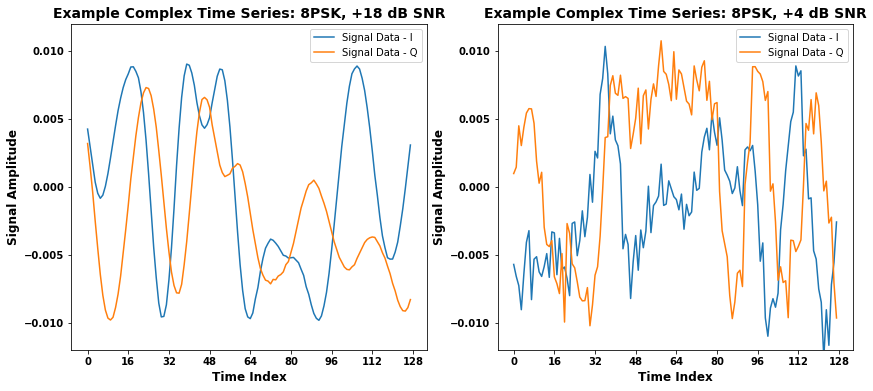

In [3]:
# Plot example I/Q timeseries
plt.figure(figsize=(14,6))

# Plot data 0 (out of range 0:999) of 8PSK, SNR +18
i_data = input_data_dict[('8PSK',18)][0][0]
q_data = input_data_dict[('8PSK',18)][0][1]

#### Fill in plot #####
plt.subplot(121)
plt.title('Example Complex Time Series: 8PSK, +18 dB SNR', fontweight='bold', fontsize=14);
plt.plot(range(0,128), i_data, range(0,128), q_data);
plt.xlabel('Time Index', fontsize=12, fontweight='bold');
plt.xticks(np.arange(0, 129, step=16), fontweight='bold', fontsize=10);
plt.ylabel('Signal Amplitude', fontsize=12, fontweight='bold');
plt.yticks(fontweight='bold', fontsize=10);
plt.legend(('Signal Data - I','Signal Data - Q'), fontsize=10, loc=1);
plt.ylim(-.012, .012);

# Plot data 0 (out of range 0:999) of 8PSK, SNR +4
i_data = input_data_dict[('8PSK',4)][0][0]
q_data = input_data_dict[('8PSK',4)][0][1]

#### Fill in plot #####
plt.subplot(122)
plt.title('Example Complex Time Series: 8PSK, +4 dB SNR', fontweight='bold', fontsize=14);
plt.plot(range(0,128), i_data, range(0,128), q_data);
plt.xlabel('Time Index', fontsize=12, fontweight='bold');
plt.xticks(np.arange(0, 129, step=16), fontweight='bold', fontsize=10);
plt.ylabel('Signal Amplitude', fontsize=12, fontweight='bold');
plt.yticks(fontweight='bold', fontsize=10);
plt.legend(('Signal Data - I','Signal Data - Q'), fontsize=10, loc=1);
plt.ylim(-.012, .012);
plt.show();

## 1.4 Create Pytorch Dataset Class

In [4]:
class myDataset(torch.utils.data.Dataset):
    def __init__(self, X,Y,Z, transform=None):
        self.X = X
        self.Y = Y
        self.Z = Z
        self.transform = transform
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        rX, rY, rZ = torch.unsqueeze(torch.from_numpy(self.X[idx]),dim=0).float(), torch.tensor(self.Y[idx]), torch.tensor(self.Z[idx])
        if(self.transform):
            rX, rY, rZ = self.transform(self.X[idx]),torch.tensor(self.Y[idx]),torch.tensor(self.Z[idx])
            
        return rX, rY, rZ

## 1.5 Create Data Arrays 

Create separate data arrays for:
 - Only Positive SNR data (0 to 18 dB)
 - Only Negative SNR data (-20 to -2 dB)
 - All data (the same as the above two combined)

In [5]:
image_psnr = []
modulation_psnr = []
snr_psnr = []

for m_cnt,m in enumerate(modulation_types,0):
    for s in snr_types[10:]:
        image_psnr.extend(input_data_dict[(m,s)])
        modulation_psnr.extend([m_cnt for _ in range(0,1000)])
        snr_psnr.extend([s for _ in range(0,1000)])
        
image_nsnr = []
modulation_nsnr = []
snr_nsnr = []

for m_cnt,m in enumerate(modulation_types,0):
    for s in snr_types[:10]:
        image_nsnr.extend(input_data_dict[(m,s)])
        modulation_nsnr.extend([m_cnt for _ in range(0,1000)])
        snr_nsnr.extend([s for _ in range(0,1000)])
        
image_asnr = []
image_asnr.extend(image_psnr)
image_asnr.extend(image_nsnr)
modulation_asnr = []
modulation_asnr.extend(modulation_psnr)
modulation_asnr.extend(modulation_nsnr)
snr_asnr = []
snr_asnr.extend(snr_psnr)
snr_asnr.extend(snr_nsnr)
        
        
image_psnr = np.array(image_psnr)
modulation_psnr = np.array(modulation_psnr)
snr_psnr = np.array(snr_psnr)

image_nsnr = np.array(image_nsnr)
modulation_nsnr = np.array(modulation_nsnr)
snr_nsnr = np.array(snr_nsnr)

image_asnr = np.array(image_asnr)
modulation_asnr = np.array(modulation_asnr)
snr_asnr = np.array(snr_asnr)

print("Number of samples in Positive SNR data array: " + str(len(image_psnr)))
print("Number of samples in Negative SNR data array: " + str(len(image_nsnr)))
print("Number of samples in All SNR data array:      " + str(len(image_asnr)))

Number of samples in Positive SNR data array: 110000
Number of samples in Negative SNR data array: 110000
Number of samples in All SNR data array:      220000


## 1.6 Create DataLoaders for Each Data Array

In [6]:
# Transform all data arrays 
transformed_dataset_psnr = myDataset(image_psnr, modulation_psnr, snr_psnr,transforms.Compose([transforms.ToTensor(),transforms.Normalize((0,),(1,))]))
transformed_dataset_nsnr = myDataset(image_nsnr, modulation_nsnr, snr_nsnr,transforms.Compose([transforms.ToTensor(),transforms.Normalize((0,),(1,))]))
transformed_dataset_asnr = myDataset(image_asnr, modulation_asnr, snr_asnr,transforms.Compose([transforms.ToTensor(),transforms.Normalize((0,),(1,))]))

# Use 50:50 train-test split for Positive SNR cases and 0:100 split for Negative SNR cases.
l = list(range(0, 110000))
np.random.shuffle(l)
split = 0.5
train_indices_psnr, test_indices_psnr = l[:int(split*110000)],l[int(split*110000):]
test_indices_nsnr = l

# Use 50:50 train-test split for All SNR cases.
l = list(range(0, 220000))
np.random.shuffle(l)
split = 0.5
train_indices_asnr, test_indices_asnr = l[:int(split*220000)],l[int(split*220000):]

# Create train/test samplers for Positive SNR data.
train_sampler_psnr = torch.utils.data.SubsetRandomSampler(train_indices_psnr)
test_sampler_psnr  = torch.utils.data.SubsetRandomSampler(test_indices_psnr)

# The separated positive/negative data arrays are used when we only train with positive data, 
# so there is no train_sampler_nsnr.
test_sampler_nsnr  = torch.utils.data.SubsetRandomSampler(test_indices_nsnr)

# Create train/test samplers for All SNR data.
train_sampler_asnr = torch.utils.data.SubsetRandomSampler(train_indices_asnr)
test_sampler_asnr  = torch.utils.data.SubsetRandomSampler(test_indices_asnr)

# Create DataLoaders for Separated Positive/Negative SNR Data Arrays
trainloader_psnr   = torch.utils.data.DataLoader(transformed_dataset_psnr, batch_size=128, shuffle=False, num_workers=2, sampler=train_sampler_psnr, pin_memory=True)
testloader_psnr    = torch.utils.data.DataLoader(transformed_dataset_psnr, batch_size=1, shuffle=False, num_workers=2, sampler=test_sampler_psnr, pin_memory=True)
testloader_nsnr    = torch.utils.data.DataLoader(transformed_dataset_nsnr, batch_size=1, shuffle=False, num_workers=2, sampler=test_sampler_nsnr, pin_memory=True)

# Create DataLoaders for All SNR Data Array
trainloader_asnr   = torch.utils.data.DataLoader(transformed_dataset_asnr, batch_size=128, shuffle=False, num_workers=2, sampler=train_sampler_asnr, pin_memory=True)
testloader_asnr    = torch.utils.data.DataLoader(transformed_dataset_asnr, batch_size=1, shuffle=False, num_workers=2, sampler=test_sampler_asnr, pin_memory=True)

# 2. Convolutional Neural Network: No Dropout

## 2.1 Define CNN Model (No Dropout)

In [7]:
class ModulationClassifier(torch.nn.Module):
    def __init__(self, num_classes=11):
        super(ModulationClassifier, self).__init__()
        
        # Treating input as 2x128 image with 1 channel (depth 1)
        self.conv1 = torch.nn.Sequential(torch.nn.Conv2d(in_channels=1, out_channels=256, kernel_size=(1,3), padding=(0,2)), torch.nn.BatchNorm2d(256))
        self.conv2 = torch.nn.Sequential(torch.nn.Conv2d(in_channels=256, out_channels=80, kernel_size=(2,3), padding=(0,2)), torch.nn.BatchNorm2d(80))
        self.classifier = torch.nn.Sequential(torch.nn.Linear(in_features=10560, out_features=256),
                                              torch.nn.ReLU(True),
                                             torch.nn.Linear(in_features=256, out_features=11))

    def forward(self, x):
        y1 = F.relu(self.conv1(x))
        y2 = F.relu(self.conv2(y1))
        y3 = torch.flatten(y2, 1)
        y4 = self.classifier(y3)
        return y4

## 2.2 Train with Positive SNR Only (0 to 18 dB)

## 2.2.1 Intialize NN, Optimizer, and Loss Function

In [8]:
net = ModulationClassifier()

learning_rate = 0.01

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net.to(device)

print(net)
for name, param in net.named_parameters():
    print('{:s}\t{:s}\t{:s}'.format(name.ljust(40), str(param.size()).ljust(30),str(param.nelement()).rjust(10)))

ModulationClassifier(
  (conv1): Sequential(
    (0): Conv2d(1, 256, kernel_size=(1, 3), stride=(1, 1), padding=(0, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(256, 80, kernel_size=(2, 3), stride=(1, 1), padding=(0, 2))
    (1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=10560, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=11, bias=True)
  )
)
conv1.0.weight                          	torch.Size([256, 1, 1, 3])    	       768
conv1.0.bias                            	torch.Size([256])             	       256
conv1.1.weight                          	torch.Size([256])             	       256
conv1.1.bias                            	torch.Size([256])             	       256
conv2.0.weight                          	torch.Size([80, 256, 2, 3])   	   

## 2.2.2 Train Neural Net with Positive SNR Data Only (0 to 18 dB)

In [9]:
num_epochs = 50
epoch_loss_array = []

for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0
    
    for i, data in enumerate(trainloader_psnr):
        x,y,z = data
        x,y,z = x.to(device), y.to(device), z.to(device)
        optimizer.zero_grad()

        y_pred = net.forward(x)   # Run batch
        loss = criterion(y_pred, y.long())  # Wants indexes for labels, *not* one-hot encodings.
        loss.backward()                               # Compute backprop
        optimizer.step()                              # Move a step in the right direction

        running_loss += loss.item()
        
    print('Epoch {:d}, Training Loss {:f}'.format(epoch,running_loss/len(trainloader_psnr)))
    epoch_loss_array.append(running_loss/len(trainloader_psnr))

print('Finished Training')

Epoch 0, Training Loss 0.789145
Epoch 1, Training Loss 0.498748
Epoch 2, Training Loss 0.441092
Epoch 3, Training Loss 0.393912
Epoch 4, Training Loss 0.369050
Epoch 5, Training Loss 0.337950
Epoch 6, Training Loss 0.308113
Epoch 7, Training Loss 0.280262
Epoch 8, Training Loss 0.249256
Epoch 9, Training Loss 0.229744
Epoch 10, Training Loss 0.205168
Epoch 11, Training Loss 0.183512
Epoch 12, Training Loss 0.157685
Epoch 13, Training Loss 0.146072
Epoch 14, Training Loss 0.130404
Epoch 15, Training Loss 0.124805
Epoch 16, Training Loss 0.109355
Epoch 17, Training Loss 0.103870
Epoch 18, Training Loss 0.098543
Epoch 19, Training Loss 0.091365
Epoch 20, Training Loss 0.086540
Epoch 21, Training Loss 0.084415
Epoch 22, Training Loss 0.081750
Epoch 23, Training Loss 0.078550
Epoch 24, Training Loss 0.073875
Epoch 25, Training Loss 0.072203
Epoch 26, Training Loss 0.071163
Epoch 27, Training Loss 0.071010
Epoch 28, Training Loss 0.069760
Epoch 29, Training Loss 0.068940
Epoch 30, Training L

### 2.2.2.1 Plot Training Loss vs Epoch

<function matplotlib.pyplot.show(*args, **kw)>

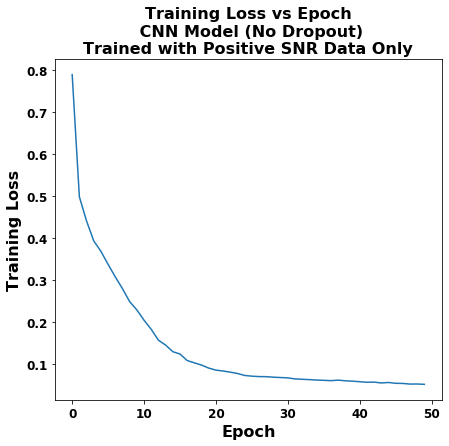

In [10]:
plt.figure(figsize=(6,6))
plt.plot(list(range(0,num_epochs)), epoch_loss_array)
plt.title('Training Loss vs Epoch\n CNN Model (No Dropout)\nTrained with Positive SNR Data Only', \
          fontweight='bold', fontsize=16)
plt.tight_layout()
plt.xlabel('Epoch', fontsize=16, fontweight='bold')
plt.ylabel('Training Loss', fontsize=16, fontweight='bold')
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.savefig('loss_vs_epoch_nodropout_5050_pos_snr.png',bbox_inches='tight')
plt.show

### 2.2.2.2 Save Model Parameters

In [11]:
PATH = './cnn_nodropout_pos_snr.pth'
torch.save(net.state_dict(), PATH) 

## 2.2.3 Test Neural Net

In [12]:
PATH = './cnn_nodropout_pos_snr.pth'
model1 = ModulationClassifier()
model1.to(device)
model1.load_state_dict(torch.load(PATH))

correct = 0
total = 0

# Helper variables for progress tracking
testloader_psnr_10pct = int(0.1*len(testloader_psnr))
testloader_nsnr_10pct = int(0.1*len(testloader_nsnr))

snr_accuracy = dict()
for i in range(-20,20,2):
    k = str(i)
    snr_accuracy[k] = [0,0]
    
model1.eval()
for i,data in enumerate(testloader_psnr):
    x,y,z = data
    x,y,z = x.to(device), y.to(device), z.to(device)

    y_pred = model1.forward(x)
    correct += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
    snr_value = z.item()

    snr_accuracy[str(int(snr_value))][0] += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
    snr_accuracy[str(int(snr_value))][1] += 1
    
    total += 1 #Increase by batch size
    
    # Print progress
    if (i%testloader_psnr_10pct == 0):
        print("testloader_psnr (Postive SNR) is %.0f%% complete" % (100 * float(i)/len(testloader_psnr)))

print("testloader_psnr (Postive SNR) is complete!\n")

for i,data in enumerate(testloader_nsnr):
    x,y,z = data
    x,y,z = x.to(device), y.to(device), z.to(device)

    y_pred = model1.forward(x)
    correct += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
    snr_value = z.item()

    snr_accuracy[str(int(snr_value))][0] += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
    snr_accuracy[str(int(snr_value))][1] += 1
    
    total += 1 #Increase by batch size
    
    # Print progress
    if (i%testloader_nsnr_10pct == 0):
        print("testloader_nsnr (testloader_nsnr SNR) is %.0f%% complete" % (100 * float(i)/len(testloader_nsnr)))

print("testloader_nsnr (testloader_nsnr SNR) is complete!\n")

# Print overall accuracy (this is not very meaningful since we have many more negative 
# SNR cases, and because accuracy is highly SNR-dependent)
print('Accuracy of the network on the test images: %f %%' % (
    100 * correct / total))

testloader_psnr (Postive SNR) is 0% complete
testloader_psnr (Postive SNR) is 10% complete
testloader_psnr (Postive SNR) is 20% complete
testloader_psnr (Postive SNR) is 30% complete
testloader_psnr (Postive SNR) is 40% complete
testloader_psnr (Postive SNR) is 50% complete
testloader_psnr (Postive SNR) is 60% complete
testloader_psnr (Postive SNR) is 70% complete
testloader_psnr (Postive SNR) is 80% complete
testloader_psnr (Postive SNR) is 90% complete
testloader_psnr (Postive SNR) is complete!

testloader_nsnr (testloader_nsnr SNR) is 0% complete
testloader_nsnr (testloader_nsnr SNR) is 10% complete
testloader_nsnr (testloader_nsnr SNR) is 20% complete
testloader_nsnr (testloader_nsnr SNR) is 30% complete
testloader_nsnr (testloader_nsnr SNR) is 40% complete
testloader_nsnr (testloader_nsnr SNR) is 50% complete
testloader_nsnr (testloader_nsnr SNR) is 60% complete
testloader_nsnr (testloader_nsnr SNR) is 70% complete
testloader_nsnr (testloader_nsnr SNR) is 80% complete
testloader_n

### 2.2.3.1 Print Model Accuracy vs SNR

In [13]:
snr_accuracy_array = []
for key, values in snr_accuracy.items():
        print('SNR {:s} Accuracy {:f} %'.format(key, 100*values[0]/values[1]))
        snr_accuracy_array.append(100*values[0]/values[1])

SNR -20 Accuracy 9.109091 %
SNR -18 Accuracy 9.018182 %
SNR -16 Accuracy 9.127273 %
SNR -14 Accuracy 9.109091 %
SNR -12 Accuracy 9.145455 %
SNR -10 Accuracy 9.281818 %
SNR -8 Accuracy 10.109091 %
SNR -6 Accuracy 13.918182 %
SNR -4 Accuracy 24.218182 %
SNR -2 Accuracy 52.327273 %
SNR 0 Accuracy 73.092224 %
SNR 2 Accuracy 78.790101 %
SNR 4 Accuracy 79.515863 %
SNR 6 Accuracy 80.779643 %
SNR 8 Accuracy 79.394495 %
SNR 10 Accuracy 80.950666 %
SNR 12 Accuracy 82.266097 %
SNR 14 Accuracy 80.601340 %
SNR 16 Accuracy 80.912477 %
SNR 18 Accuracy 80.377907 %


### 2.2.3.2 Plot Model Accuracy vs SNR

<function matplotlib.pyplot.show(*args, **kw)>

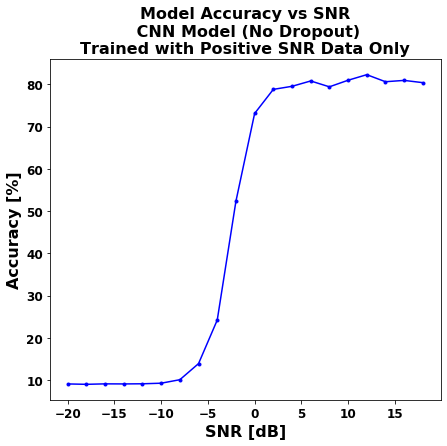

In [14]:
plt.figure(figsize=(6,6))
plt.plot(snr_types, snr_accuracy_array,'b.-')
plt.title('Model Accuracy vs SNR\n CNN Model (No Dropout)\nTrained with Positive SNR Data Only', \
          fontweight='bold', fontsize=16)
plt.tight_layout()
plt.xlabel('SNR [dB]', fontsize=16, fontweight='bold')
plt.ylabel('Accuracy [%]', fontsize=16, fontweight='bold')
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.savefig('accuracy_vs_snr_nodropout_5050_pos_snr.png',bbox_inches='tight')
plt.show

## 2.3 Train with All SNR Data (-20 to 18 dB)

## 2.3.1 Intialize NN, Optimizer, and Loss Function

In [15]:
net = ModulationClassifier()

learning_rate = 0.01

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(len(transformed_dataset_psnr))
print(len(trainloader_psnr))

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)
net.to(device)

print(net)
for name, param in net.named_parameters():
    #if param.requires_grad:
    print('{:s}\t{:s}\t{:s}'.format(name.ljust(40), str(param.size()).ljust(30),str(param.nelement()).rjust(10)))

110000
430
cuda:0
ModulationClassifier(
  (conv1): Sequential(
    (0): Conv2d(1, 256, kernel_size=(1, 3), stride=(1, 1), padding=(0, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(256, 80, kernel_size=(2, 3), stride=(1, 1), padding=(0, 2))
    (1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=10560, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=11, bias=True)
  )
)
conv1.0.weight                          	torch.Size([256, 1, 1, 3])    	       768
conv1.0.bias                            	torch.Size([256])             	       256
conv1.1.weight                          	torch.Size([256])             	       256
conv1.1.bias                            	torch.Size([256])             	       256
conv2.0.weight                          	torch.Size([80, 

## 2.3.2 Train Neural Net with All SNR Data (-20 to 18 dB)

In [16]:
num_epochs = 50
epoch_loss_array = []

for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0
    
    for i, data in enumerate(trainloader_asnr):
        x,y,z = data
        x,y,z = x.to(device), y.to(device), z.to(device)
        optimizer.zero_grad()

        y_pred = net.forward(x)   # Run batch
        loss = criterion(y_pred, y.long())  # Wants indexes for labels, *not* one-hot encodings.
        loss.backward()                               # Compute backprop
        optimizer.step()                              # Move a step in the right direction

        running_loss += loss.item()
        
    print('Epoch {:d}, Training Loss {:f}'.format(epoch,running_loss/len(trainloader_asnr)))
    epoch_loss_array.append(running_loss/len(trainloader_asnr))
#     print(running_loss/len(trainloader_asnr))
#     epoch_loss_array.append(running_loss/len(trainloader_asnr))

print('Finished Training')

Epoch 0, Training Loss 1.486241
Epoch 1, Training Loss 1.294752
Epoch 2, Training Loss 1.234539
Epoch 3, Training Loss 1.185756
Epoch 4, Training Loss 1.130959
Epoch 5, Training Loss 1.067249
Epoch 6, Training Loss 0.991803
Epoch 7, Training Loss 0.894353
Epoch 8, Training Loss 0.784476
Epoch 9, Training Loss 0.653803
Epoch 10, Training Loss 0.511361
Epoch 11, Training Loss 0.385078
Epoch 12, Training Loss 0.276713
Epoch 13, Training Loss 0.199086
Epoch 14, Training Loss 0.149163
Epoch 15, Training Loss 0.121502
Epoch 16, Training Loss 0.093768
Epoch 17, Training Loss 0.080486
Epoch 18, Training Loss 0.073888
Epoch 19, Training Loss 0.058665
Epoch 20, Training Loss 0.051414
Epoch 21, Training Loss 0.047546
Epoch 22, Training Loss 0.043746
Epoch 23, Training Loss 0.040636
Epoch 24, Training Loss 0.039374
Epoch 25, Training Loss 0.037687
Epoch 26, Training Loss 0.037940
Epoch 27, Training Loss 0.036882
Epoch 28, Training Loss 0.037046
Epoch 29, Training Loss 0.038626
Epoch 30, Training L

### 2.3.2.1 Plot Training Loss vs Epoch

<function matplotlib.pyplot.show(*args, **kw)>

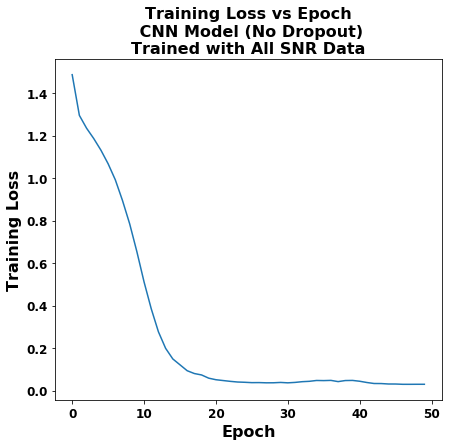

In [17]:
plt.figure(figsize=(6,6))
plt.plot(list(range(0,num_epochs)), epoch_loss_array)
plt.title('Training Loss vs Epoch\n CNN Model (No Dropout)\nTrained with All SNR Data', \
          fontweight='bold', fontsize=16)
plt.tight_layout()
plt.xlabel('Epoch', fontsize=16, fontweight='bold')
plt.ylabel('Training Loss', fontsize=16, fontweight='bold')
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.savefig('loss_vs_epoch_nodropout_5050_all_snr.png',bbox_inches='tight')
plt.show

### 2.3.2.2 Save Model Parameters

In [18]:
PATH = './cnn_nodropout_all_snr.pth'
torch.save(net.state_dict(), PATH) 

## 2.3.3 Test Neural Net

In [19]:
PATH = './cnn_nodropout_all_snr.pth'

model1 = ModulationClassifier()
model1.to(device)
model1.load_state_dict(torch.load(PATH))

correct = 0
total = 0

# Helper variables for progress tracking
testloader_asnr_10pct = int(0.1*len(testloader_asnr))

snr_accuracy = dict()
for i in range(-20,20,2):
    k = str(i)
    snr_accuracy[k] = [0,0]
    
model1.eval()
for i,data in enumerate(testloader_asnr):
    x,y,z = data
    x,y,z = x.to(device), y.to(device), z.to(device)

    y_pred = model1.forward(x)
    correct += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
    snr_value = z.item()

    snr_accuracy[str(int(snr_value))][0] += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
    snr_accuracy[str(int(snr_value))][1] += 1
    
    total += 1 #Increase by batch size
    
    # Print progress
    if (i%testloader_asnr_10pct == 0):
        print("testloader_asnr (All SNR) is %.0f%% complete" % (100 * float(i)/len(testloader_asnr)))

print("testloader_asnr (All SNR) is complete!\n")

# Print overall accuracy (this is not very meaningful since we have many more negative 
# SNR cases, and because accuracy is highly SNR-dependent)
print('Accuracy of the network on the test images: %f %%' % (
    100 * correct / total))

testloader_asnr (All SNR) is 0% complete
testloader_asnr (All SNR) is 10% complete
testloader_asnr (All SNR) is 20% complete
testloader_asnr (All SNR) is 30% complete
testloader_asnr (All SNR) is 40% complete
testloader_asnr (All SNR) is 50% complete
testloader_asnr (All SNR) is 60% complete
testloader_asnr (All SNR) is 70% complete
testloader_asnr (All SNR) is 80% complete
testloader_asnr (All SNR) is 90% complete
testloader_asnr (All SNR) is complete!

Accuracy of the network on the test images: 48.360000 %


### 2.3.3.1 Print Model Accuracy vs SNR

In [20]:
snr_accuracy_array = []
for key, values in snr_accuracy.items():
    if(values[1]):
        print('SNR {:s} Accuracy {:f}'.format(key, 100*values[0]/values[1]))
        snr_accuracy_array.append(100*values[0]/values[1])

SNR -20 Accuracy 8.888889
SNR -18 Accuracy 9.306504
SNR -16 Accuracy 10.049064
SNR -14 Accuracy 11.499272
SNR -12 Accuracy 13.496821
SNR -10 Accuracy 17.083708
SNR -8 Accuracy 25.167603
SNR -6 Accuracy 34.699104
SNR -4 Accuracy 44.895359
SNR -2 Accuracy 56.906579
SNR 0 Accuracy 66.250917
SNR 2 Accuracy 70.755908
SNR 4 Accuracy 72.044179
SNR 6 Accuracy 74.420290
SNR 8 Accuracy 74.805148
SNR 10 Accuracy 76.857091
SNR 12 Accuracy 75.299982
SNR 14 Accuracy 75.548185
SNR 16 Accuracy 74.799270
SNR 18 Accuracy 75.613276


### 2.3.3.2 Plot Model Accuracy vs SNR

<function matplotlib.pyplot.show(*args, **kw)>

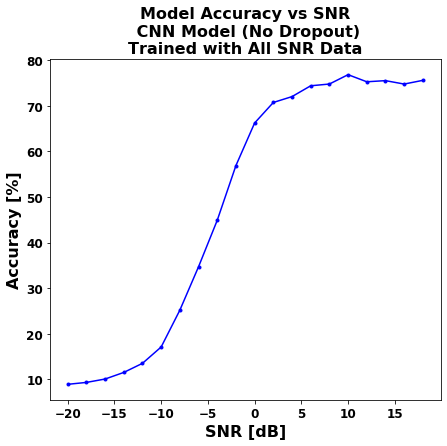

In [21]:
plt.figure(figsize=(6,6))
plt.plot(snr_types, snr_accuracy_array,'b.-')
plt.title('Model Accuracy vs SNR\n CNN Model (No Dropout)\nTrained with All SNR Data', \
          fontweight='bold', fontsize=16)
plt.tight_layout()
plt.xlabel('SNR [dB]', fontsize=16, fontweight='bold')
plt.ylabel('Accuracy [%]', fontsize=16, fontweight='bold')
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.savefig('accuracy_vs_snr_nodropout_5050_all_snr.png',bbox_inches='tight')
plt.show

## 2.4 Modify Train/Test Split Ratio and Check for Overfitting
### In 2.2 and 2.3 we showed that training with only positive SNR data helped our model accuracy. Let's try again training with Positive SNR Only, but with a 70:30 Train/Test Split for the Positive SNR Data. Let's also add Validation to determine whether our model is overfitting.

## 2.4.1 Create New DataLoaders with 70:30 Train/Test Split for Positive SNR Data

In [22]:
dataset_len = 110000
l = list(range(0, dataset_len))
np.random.shuffle(l)

split = 0.7
train_indices, test_indices = l[:int(split*dataset_len)], l[int(split*dataset_len):]

valsplit = 0.5
test_indices, val_indices = test_indices[:int(valsplit*len(test_indices))], test_indices[int(valsplit*len(test_indices)):]

print(len(train_indices), len(test_indices),len(val_indices))

train_sampler=torch.utils.data.SubsetRandomSampler(train_indices)
test_sampler=torch.utils.data.SubsetRandomSampler(test_indices)
val_sampler=torch.utils.data.SubsetRandomSampler(val_indices)

trainloader = torch.utils.data.DataLoader(transformed_dataset_psnr, batch_size=128, shuffle=False, num_workers=2, sampler=train_sampler, pin_memory=True)
valloader   = torch.utils.data.DataLoader(transformed_dataset_psnr, batch_size=128, shuffle=False, num_workers=2, sampler=val_sampler, pin_memory=True)
testloader1 = torch.utils.data.DataLoader(transformed_dataset_psnr, batch_size=1, shuffle=False, num_workers=2, sampler=test_sampler, pin_memory=True)
testloader2 = torch.utils.data.DataLoader(transformed_dataset_nsnr, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

77000 16500 16500


## 2.4.2 Intialize NN, Optimizer, and Loss Function

In [23]:
net = ModulationClassifier()

learning_rate = 0.01

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)
net.to(device)

print(net)
for name, param in net.named_parameters():
    #if param.requires_grad:
    print('{:s}\t{:s}\t{:s}'.format(name.ljust(40), str(param.size()).ljust(30),str(param.nelement()).rjust(10)))

cuda:0
ModulationClassifier(
  (conv1): Sequential(
    (0): Conv2d(1, 256, kernel_size=(1, 3), stride=(1, 1), padding=(0, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(256, 80, kernel_size=(2, 3), stride=(1, 1), padding=(0, 2))
    (1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=10560, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=11, bias=True)
  )
)
conv1.0.weight                          	torch.Size([256, 1, 1, 3])    	       768
conv1.0.bias                            	torch.Size([256])             	       256
conv1.1.weight                          	torch.Size([256])             	       256
conv1.1.bias                            	torch.Size([256])             	       256
conv2.0.weight                          	torch.Size([80, 256, 2, 3])

## 2.4.3 Define Function for Testing Against Validation Data (No Dropout)

In [24]:
def validation_function(net, criterion):
    PATH = './temp_model_val.pth'
    torch.save(net.state_dict(), PATH) 

    model1 = ModulationClassifier()
    model1.to(device)
    model1.load_state_dict(torch.load(PATH))
    
    val_loss = 0
    total = 0
    model1.eval()
    for i, data in enumerate(valloader):
        xv, yv, zv = data
        xv, yv, zv = xv.to(device), yv.to(device), zv.to(device)

        yv_pred = model1.forward(xv)
        batchv_loss = criterion(yv_pred, yv.long())
        val_loss += batchv_loss.item()

        total += 128
        
    #print(val_loss)
        
    return val_loss

## 2.4.4 Train Neural Net and Test with Validation Data

In [25]:
num_epochs = 25
epoch_loss_array = np.zeros(num_epochs)

historyEpoch = []
historyLoss = []
historyValLoss = []

for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0
    correct_test = 0
    historyEpoch.append(epoch)
    
    for i, data in enumerate(trainloader):
        x,y,z = data
        x,y,z = x.to(device), y.to(device), z.to(device)
        optimizer.zero_grad()

        y_pred = net.forward(x)   # Run batch
        correct_test += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
        loss = criterion(y_pred, y.long())  # Wants indexes for labels, *not* one-hot encodings.
        #print(y_pred)
        #print(loss.item())
        loss.backward()                               # Compute backprop
        optimizer.step()                              # Move a step in the right direction

        running_loss += loss.item()
        
    valloss = validation_function(net, criterion)
    print("Epoch #", epoch, 'Correct:', correct_test,"Loss: ", running_loss/len(trainloader), 'Val Loss', valloss/len(valloader))
    historyLoss.append(running_loss/len(trainloader))
    historyValLoss.append(valloss/len(valloader))

print('Finished Training')
plt.show()

Epoch # 0 Correct: 52583 Loss:  0.7095697977614165 Val Loss 0.5190628515195477
Epoch # 1 Correct: 59105 Loss:  0.471383117906675 Val Loss 0.4524744520353716
Epoch # 2 Correct: 60706 Loss:  0.41555786078356427 Val Loss 0.42659318909164545
Epoch # 3 Correct: 62032 Loss:  0.37866351929217873 Val Loss 0.4045989451020263
Epoch # 4 Correct: 63287 Loss:  0.34560394249980236 Val Loss 0.3997812153295029
Epoch # 5 Correct: 64395 Loss:  0.3182706222482694 Val Loss 0.3989905349968016
Epoch # 6 Correct: 65670 Loss:  0.2888966033427026 Val Loss 0.40754417740097343
Epoch # 7 Correct: 66322 Loss:  0.27000091356098455 Val Loss 0.41764926436797595
Epoch # 8 Correct: 67443 Loss:  0.24522450190049866 Val Loss 0.43092985301054726
Epoch # 9 Correct: 68254 Loss:  0.22392079424719477 Val Loss 0.45434394859990407
Epoch # 10 Correct: 69182 Loss:  0.20485967082092135 Val Loss 0.45165598288524983
Epoch # 11 Correct: 69855 Loss:  0.1861614754974248 Val Loss 0.4770170422487481
Epoch # 12 Correct: 70424 Loss:  0.171

### 2.4.4.1 Plot Training and Validation Loss vs Epoch

<function matplotlib.pyplot.show(*args, **kw)>

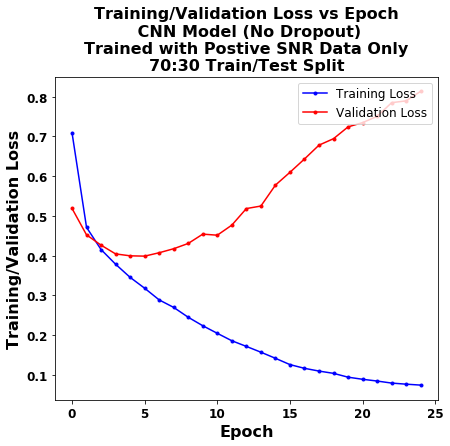

In [26]:
plt.figure(figsize=(6,6))
plt.plot(historyEpoch, historyLoss, 'b.-')
plt.plot(historyEpoch, historyValLoss,'r.-')
plt.legend(('Training Loss','Validation Loss'), fontsize=12, loc=1);
plt.title('Training/Validation Loss vs Epoch\n CNN Model (No Dropout)\nTrained with Postive SNR Data Only\n70:30 Train/Test Split', \
          fontweight='bold', fontsize=16)
plt.tight_layout()
plt.xlabel('Epoch', fontsize=16, fontweight='bold')
plt.ylabel('Training/Validation Loss', fontsize=16, fontweight='bold')
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.savefig('loss_vs_epoch_nodropout_7030_pos_snr_withval.png',bbox_inches='tight')
plt.show

### 2.4.4.2 Plot Training and Validation Loss vs Epoch (Paper Version)

<function matplotlib.pyplot.show(*args, **kw)>

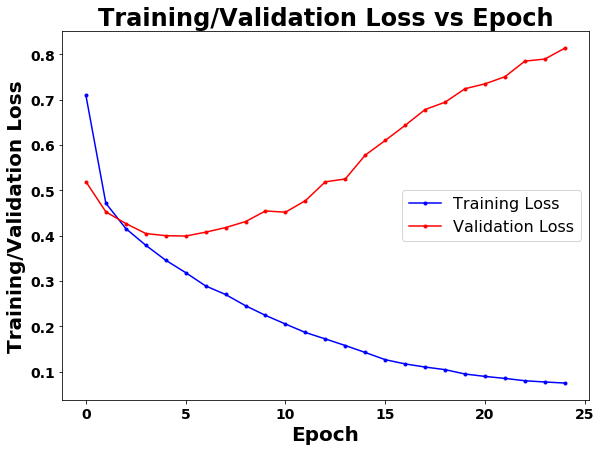

In [27]:
# plt.figure()
# plt.title('Training performance')
# plt.plot(historyEpoch, historyLoss, 'b.-')
# plt.plot(historyEpoch, historyValLoss,'r.-')
# plt.legend(('Training Loss','Validation Loss'), fontsize=10, loc=1);

plt.figure(figsize=(8,6))
plt.plot(historyEpoch, historyLoss, 'b.-')
plt.plot(historyEpoch, historyValLoss,'r.-')
plt.legend(('Training Loss','Validation Loss'), fontsize=16, loc=5);
plt.title('Training/Validation Loss vs Epoch', \
          fontweight='bold', fontsize=24)
plt.tight_layout()
plt.xlabel('Epoch', fontsize=20, fontweight='bold')
plt.ylabel('Training/Validation Loss', fontsize=20, fontweight='bold')
plt.xticks(fontweight='bold', fontsize=14)
plt.yticks(fontweight='bold', fontsize=14)
plt.savefig('loss_vs_epoch_nodropout_final.png',bbox_inches='tight')
plt.show

### 2.4.4.3 Save Model Parameters

In [28]:
PATH = './cnn_nodropout_70_30_pos_snr.pth'
torch.save(net.state_dict(), PATH) 

## 2.4.5 Test Neural Net

In [29]:
PATH = './cnn_nodropout_70_30_pos_snr.pth'

model1 = ModulationClassifier()
model1.to(device)
model1.load_state_dict(torch.load(PATH))

correct = 0
total = 0

# Helper variables for progress tracking
testloader1_10pct = int(0.1*len(testloader1))
testloader2_10pct = int(0.1*len(testloader2))

snr_accuracy = dict()
for i in range(-20,20,2):
    k = str(i)
    snr_accuracy[k] = [0,0]
    
model1.eval()
for i,data in enumerate(testloader1):
    x,y,z = data
    x,y,z = x.to(device), y.to(device), z.to(device)

    y_pred = model1.forward(x)
    correct += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
    snr_value = z.item()

    snr_accuracy[str(int(snr_value))][0] += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
    snr_accuracy[str(int(snr_value))][1] += 1
    
    total += 1 #Increase by batch size
    
    # Print progress
    if (i%testloader1_10pct == 0):
        print("testloader1 (Positive SNR) is %.0f%% complete" % (100 * float(i)/len(testloader1)))

print("testloader1 (Positive SNR) is complete!\n")

for i,data in enumerate(testloader2):
    x,y,z = data
    x,y,z = x.to(device), y.to(device), z.to(device)

    y_pred = model1.forward(x)
    correct += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
    snr_value = z.item()

    snr_accuracy[str(int(snr_value))][0] += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
    snr_accuracy[str(int(snr_value))][1] += 1
    
    total += 1 #Increase by batch size
    
    # Print progress
    if (i%testloader2_10pct == 0):
        print("testloader2 (Negative SNR) is %.0f%% complete" % (100 * float(i)/len(testloader2)))

print("testloader2 (Negative SNR) is complete!\n")

# Print overall accuracy (this is not very meaningful since we have many more negative 
# SNR cases, and because accuracy is highly SNR-dependent)
print('Accuracy of the network on the test images: %f %%' % (
    100 * correct / total))

testloader1 (Positive SNR) is 0% complete
testloader1 (Positive SNR) is 10% complete
testloader1 (Positive SNR) is 20% complete
testloader1 (Positive SNR) is 30% complete
testloader1 (Positive SNR) is 40% complete
testloader1 (Positive SNR) is 50% complete
testloader1 (Positive SNR) is 60% complete
testloader1 (Positive SNR) is 70% complete
testloader1 (Positive SNR) is 80% complete
testloader1 (Positive SNR) is 90% complete
testloader1 (Positive SNR) is complete!

testloader2 (Negative SNR) is 0% complete
testloader2 (Negative SNR) is 10% complete
testloader2 (Negative SNR) is 20% complete
testloader2 (Negative SNR) is 30% complete
testloader2 (Negative SNR) is 40% complete
testloader2 (Negative SNR) is 50% complete
testloader2 (Negative SNR) is 60% complete
testloader2 (Negative SNR) is 70% complete
testloader2 (Negative SNR) is 80% complete
testloader2 (Negative SNR) is 90% complete
testloader2 (Negative SNR) is complete!

Accuracy of the network on the test images: 24.527273 %


### 2.4.5.1 Print Model Accuracy vs SNR

In [30]:
snr_accuracy_array = []
for key, values in snr_accuracy.items():
    if(values[1]):
        print('SNR {:s} Accuracy {:f}'.format(key, 100*values[0]/values[1]))
        snr_accuracy_array.append(100*values[0]/values[1])

SNR -20 Accuracy 9.063636
SNR -18 Accuracy 9.090909
SNR -16 Accuracy 9.054545
SNR -14 Accuracy 9.036364
SNR -12 Accuracy 9.072727
SNR -10 Accuracy 9.300000
SNR -8 Accuracy 10.090909
SNR -6 Accuracy 13.881818
SNR -4 Accuracy 25.945455
SNR -2 Accuracy 56.363636
SNR 0 Accuracy 75.284261
SNR 2 Accuracy 79.814815
SNR 4 Accuracy 81.483791
SNR 6 Accuracy 82.071472
SNR 8 Accuracy 80.094229
SNR 10 Accuracy 81.050657
SNR 12 Accuracy 81.834862
SNR 14 Accuracy 81.355932
SNR 16 Accuracy 82.244656
SNR 18 Accuracy 82.562278


### 2.4.5.2 Plot Model Accuracy vs SNR

<function matplotlib.pyplot.show(*args, **kw)>

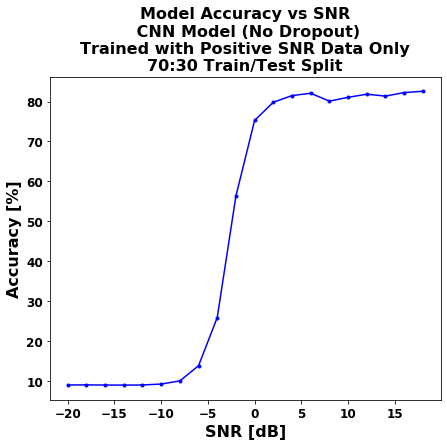

In [31]:
# plt.plot(snr_types, snr_accuracy_array,'b.-')
# plt.xlabel('SNR in dB')
# plt.ylabel('Accuracy')
# plt.title('Accuracy vs SNR')
# plt.show()

plt.figure(figsize=(6,6))
plt.plot(snr_types, snr_accuracy_array,'b.-')
plt.title('Model Accuracy vs SNR\n CNN Model (No Dropout)\nTrained with Positive SNR Data Only\n70:30 Train/Test Split', \
          fontweight='bold', fontsize=16)
plt.tight_layout()
plt.xlabel('SNR [dB]', fontsize=16, fontweight='bold')
plt.ylabel('Accuracy [%]', fontsize=16, fontweight='bold')
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.savefig('accuracy_vs_snr_nodropout_7030_pos_snr.png',bbox_inches='tight')
plt.show

# 3. Convolutional Neural Network: With Dropout

## 3.1 Define CNN Model (With Dropout)

In [32]:
class ModulationClassifierDropout(torch.nn.Module):
    def __init__(self, num_classes=11):
        super(ModulationClassifierDropout, self).__init__()
        
        # Treating input as 2x128 image with 1 channel (depth 1)
        self.conv1 = torch.nn.Sequential(torch.nn.Conv2d(in_channels=1, out_channels=256, kernel_size=(1,3), padding=(0,2)), torch.nn.BatchNorm2d(256))
        self.conv2 = torch.nn.Sequential(torch.nn.Conv2d(in_channels=256, out_channels=80, kernel_size=(2,3), padding=(0,2)), torch.nn.BatchNorm2d(80))
        self.drop1 = torch.nn.Dropout(0.50)
        self.classifier = torch.nn.Sequential(torch.nn.Linear(in_features=10560, out_features=256),
                                              torch.nn.ReLU(True),
                                             torch.nn.Linear(in_features=256, out_features=11))

    def forward(self, x):
        y1 = F.relu(self.conv1(x))
        y2 = self.drop1(y1)
        y3 = F.relu(self.conv2(y2))
        y4 = self.drop1(y3)
        y5 = torch.flatten(y4, 1)
        y6 = self.drop1(y5)
        y7 = self.classifier(y6)
        return y7

## 3.2 Train with Positive SNR Only (0 to 18 dB) and 70:30 Train/Test Split 

## 3.2.1 Create New DataLoaders with 70:30 Train/Test Split for Positive SNR Data

In [33]:
dataset_len = 110000
l = list(range(0, dataset_len))
np.random.shuffle(l)

split = 0.7
train_indices, test_indices = l[:int(split*dataset_len)], l[int(split*dataset_len):]

valsplit = 0.5
test_indices, val_indices = test_indices[:int(valsplit*len(test_indices))], test_indices[int(valsplit*len(test_indices)):]

print(len(train_indices), len(test_indices),len(val_indices))

train_sampler=torch.utils.data.SubsetRandomSampler(train_indices)
test_sampler=torch.utils.data.SubsetRandomSampler(test_indices)
val_sampler=torch.utils.data.SubsetRandomSampler(val_indices)

trainloader = torch.utils.data.DataLoader(transformed_dataset_psnr, batch_size=128, shuffle=False, num_workers=2, sampler=train_sampler, pin_memory=True)
valloader   = torch.utils.data.DataLoader(transformed_dataset_psnr, batch_size=128, shuffle=False, num_workers=2, sampler=val_sampler, pin_memory=True)
testloader1 = torch.utils.data.DataLoader(transformed_dataset_psnr, batch_size=1, shuffle=False, num_workers=2, sampler=test_sampler, pin_memory=True)
testloader2 = torch.utils.data.DataLoader(transformed_dataset_nsnr, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

77000 16500 16500


## 3.2.2 Intialize NN, Optimizer, and Loss Function

In [34]:
net = ModulationClassifierDropout()

learning_rate = 0.001

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net.to(device)

print(net)
for name, param in net.named_parameters():
    print('{:s}\t{:s}\t{:s}'.format(name.ljust(40), str(param.size()).ljust(30),str(param.nelement()).rjust(10)))

ModulationClassifierDropout(
  (conv1): Sequential(
    (0): Conv2d(1, 256, kernel_size=(1, 3), stride=(1, 1), padding=(0, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(256, 80, kernel_size=(2, 3), stride=(1, 1), padding=(0, 2))
    (1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (drop1): Dropout(p=0.5, inplace=False)
  (classifier): Sequential(
    (0): Linear(in_features=10560, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=11, bias=True)
  )
)
conv1.0.weight                          	torch.Size([256, 1, 1, 3])    	       768
conv1.0.bias                            	torch.Size([256])             	       256
conv1.1.weight                          	torch.Size([256])             	       256
conv1.1.bias                            	torch.Size([256])             	       256
conv2.0.weight             

## 3.2.3 Define Function for Testing Against Validation Data (With Dropout)

In [35]:
def validation_function_dropout(net, criterion):
    PATH = './temp_model_val_do.pth'
    torch.save(net.state_dict(), PATH) 

    model1 = ModulationClassifierDropout()
    model1.to(device)
    model1.load_state_dict(torch.load(PATH))
    
    val_loss = 0
    total = 0
    model1.eval()
    for i, data in enumerate(valloader):
        xv, yv, zv = data
        xv, yv, zv = xv.to(device), yv.to(device), zv.to(device)

        yv_pred = model1.forward(xv)
        batchv_loss = criterion(yv_pred, yv.long())
        val_loss += batchv_loss.item()

        total += 128
        
    #print(val_loss)
        
    return val_loss

## 3.2.4 Train Neural Net and Test with Validation Data

In [36]:
num_epochs = 100
epoch_loss_array = np.zeros(num_epochs)

historyEpoch = []
historyLoss = []
historyValLoss = []

for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0
    correct_test = 0
    historyEpoch.append(epoch)
    
    for i, data in enumerate(trainloader):
        x,y,z = data
        x,y,z = x.to(device), y.to(device), z.to(device)
        optimizer.zero_grad()

        y_pred = net.forward(x)   # Run batch
        correct_test += torch.sum((torch.argmax(y_pred,dim=1) == y)).item()
        loss = criterion(y_pred, y.long())  # Wants indexes for labels, *not* one-hot encodings.
        #print(y_pred)
        #print(loss.item())
        loss.backward()                               # Compute backprop
        optimizer.step()                              # Move a step in the right direction

        running_loss += loss.item()
        
    valloss = validation_function(net, criterion)
    print("Epoch #", epoch, 'Correct:', correct_test,"Loss: ", running_loss/len(trainloader), 'Val Loss', valloss/len(valloader))
    historyLoss.append(running_loss/len(trainloader))
    historyValLoss.append(valloss/len(valloader))

print('Finished Training')
plt.show()

Epoch # 0 Correct: 29988 Loss:  1.6194308254607888 Val Loss 0.9968990970027539
Epoch # 1 Correct: 47771 Loss:  0.9040527507118212 Val Loss 0.7049602043721103
Epoch # 2 Correct: 51812 Loss:  0.7313393228671875 Val Loss 0.5926670274993245
Epoch # 3 Correct: 53531 Loss:  0.6572510364443757 Val Loss 0.560403995504675
Epoch # 4 Correct: 54425 Loss:  0.6147732550519646 Val Loss 0.5298490605151006
Epoch # 5 Correct: 55271 Loss:  0.5868098118475505 Val Loss 0.5118830663751263
Epoch # 6 Correct: 56155 Loss:  0.5602191733660492 Val Loss 0.491472546213357
Epoch # 7 Correct: 56937 Loss:  0.5411413268888512 Val Loss 0.47871327423310095
Epoch # 8 Correct: 57573 Loss:  0.5223049101639428 Val Loss 0.4470919176589611
Epoch # 9 Correct: 58070 Loss:  0.508010250290367 Val Loss 0.4492157436618509
Epoch # 10 Correct: 58568 Loss:  0.4974926015566354 Val Loss 0.4464719741381416
Epoch # 11 Correct: 58803 Loss:  0.4907190518026732 Val Loss 0.4314521269280781
Epoch # 12 Correct: 58972 Loss:  0.4793610061917986 

### 3.2.4.1 Plot Training and Validation Loss vs Epoch

<function matplotlib.pyplot.show(*args, **kw)>

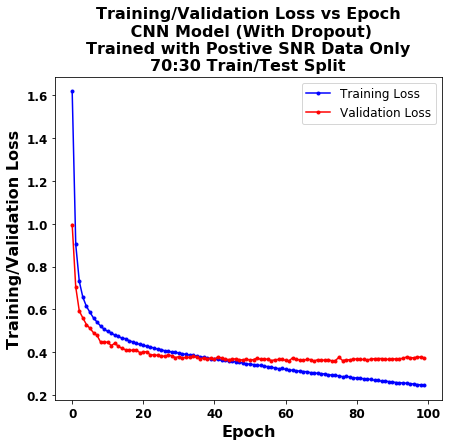

In [37]:
# plt.figure()
# plt.title('Training performance')
# plt.plot(historyEpoch, historyLoss, 'b.-',label='train loss')
# plt.plot(historyEpoch, historyValLoss,'r.-', label='val_error')
# plt.legend()

plt.figure(figsize=(6,6))
plt.plot(historyEpoch, historyLoss, 'b.-')
plt.plot(historyEpoch, historyValLoss,'r.-')
plt.legend(('Training Loss','Validation Loss'), fontsize=12, loc=1);
plt.title('Training/Validation Loss vs Epoch\n CNN Model (With Dropout)\nTrained with Postive SNR Data Only\n70:30 Train/Test Split', \
          fontweight='bold', fontsize=16)
plt.tight_layout()
plt.xlabel('Epoch', fontsize=16, fontweight='bold')
plt.ylabel('Training/Validation Loss', fontsize=16, fontweight='bold')
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
plt.savefig('loss_vs_epoch_dropout_7030_pos_snr_withval.png',bbox_inches='tight')
plt.show

### 3.2.4.2 Plot Training and Validation Loss vs Epoch (Paper Version)

<function matplotlib.pyplot.show(*args, **kw)>

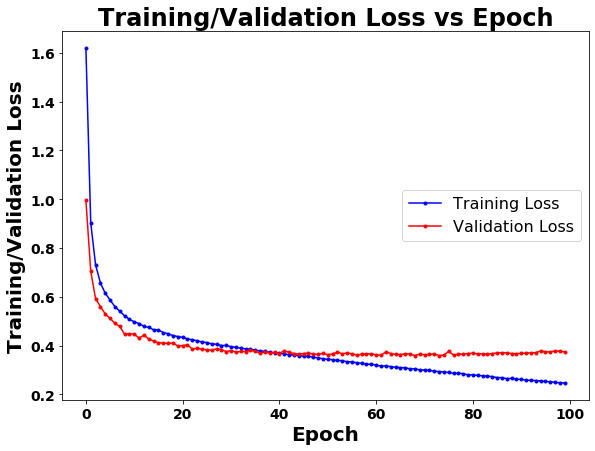

In [38]:
plt.figure(figsize=(8,6))
plt.plot(historyEpoch, historyLoss, 'b.-')
plt.plot(historyEpoch, historyValLoss,'r.-')
plt.legend(('Training Loss','Validation Loss'), fontsize=16, loc=5);
plt.title('Training/Validation Loss vs Epoch', \
          fontweight='bold', fontsize=24)
plt.tight_layout()
plt.xlabel('Epoch', fontsize=20, fontweight='bold')
plt.ylabel('Training/Validation Loss', fontsize=20, fontweight='bold')
plt.xticks(fontweight='bold', fontsize=14)
plt.yticks(fontweight='bold', fontsize=14)
plt.savefig('loss_vs_epoch_final.png',bbox_inches='tight')
plt.show

### 3.2.4.3 Save Model Parameters

In [39]:
PATH = './cnn_dropout_70_30_pos_snr.pth'
torch.save(net.state_dict(), PATH) 

## 3.2.5 Test Neural Net & Collect Confusion Matrix Data

In [40]:
PATH = './cnn_dropout_70_30_pos_snr.pth'

model1 = ModulationClassifierDropout()
model1.to(device)
model1.load_state_dict(torch.load(PATH))

overall_correct = 0
overall_total = 0

# Helper variables
num_mods = len(modulation_types)
testloader1_10pct = int(0.1*len(testloader1))
testloader2_10pct = int(0.1*len(testloader2))


# snr_accuracy dictionary has keys that are SNRs and values that are [2,1] matrices.
# First element = number of correct 
snr_accuracy = dict()
for i in range(-20,20,2):
    k = str(i)
    snr_accuracy[k] = [0,0]

    
# confusion_totals dictionary has keys that are SNRs and values that are 11x11 matrices. 
# Row = true modulation, Column = model-predicted modulation.  Matrix elements are counts of occurance. 
# Example: confusion_totals['8'][3,2] = 4 would mean that there were 4 data samples at +8 dB SNR 
#          of modulation BPSK that were misclassified by the model as AM-SSB.
# confusion_percentages will be the same as confusion_totals, but normalized by true modulation.
confusion_totals = dict()
confusion_pcts = dict()
for i in range(-20,20,2):
    k = str(i)
    confusion_totals[k] = np.zeros((num_mods,num_mods))
    confusion_pcts[k] = np.zeros((num_mods,num_mods))

    
# Evaluate and categorize Positive SNR test data by SNR, true modulation, and predicted modulation
model1.eval()
for i,data in enumerate(testloader1):
    x,y,z = data
    x,y,z = x.to(device), y.to(device), z.to(device)
    
    pred_mod = model1.forward(x)
    pred_mod_idx = torch.argmax(pred_mod,dim=1).item()
    true_mod_idx = y.item()
    snr_value = z.item()

    # Track accuracy (overall and per-SNR)
    overall_correct += torch.sum((torch.argmax(pred_mod,dim=1) == y)).item()
    overall_total += 1 #Increase by batch size
    snr_accuracy[str(int(snr_value))][0] += torch.sum((torch.argmax(pred_mod,dim=1) == y)).item()
    snr_accuracy[str(int(snr_value))][1] += 1
    
    # Increment appropriate confusion matrix element 
    confusion_totals[str(int(snr_value))][true_mod_idx,pred_mod_idx] += 1
    
    # Print progress
    if (i%testloader1_10pct == 0):
        print("testloader1 (Positive SNR) is %.0f%% complete" % (100 * float(i)/len(testloader1)))

print("testloader1 (Positive SNR) is complete!\n")
        
    
# Evaluate and categorize Negative SNR test data by SNR, true modulation, and predicted modulation
for i,data in enumerate(testloader2):
    x,y,z = data
    x,y,z = x.to(device), y.to(device), z.to(device)
    
    pred_mod = model1.forward(x)
    pred_mod_idx = torch.argmax(pred_mod,dim=1).item()
    true_mod_idx = y.item()
    snr_value = z.item()

    # Track accuracy (overall and per-SNR)
    overall_correct += torch.sum((torch.argmax(pred_mod,dim=1) == y)).item()
    overall_total += 1 #Increase by batch size
    snr_accuracy[str(int(snr_value))][0] += torch.sum((torch.argmax(pred_mod,dim=1) == y)).item()
    snr_accuracy[str(int(snr_value))][1] += 1
    
    # Increment appropriate confusion matrix element 
    confusion_totals[str(int(snr_value))][true_mod_idx,pred_mod_idx] += 1
    
    # Print progress
    if (i%testloader2_10pct == 0):
        print("testloader2 (Negative SNR) is %.0f%% complete" % (100 * float(i)/len(testloader2)))

print("testloader2 (Negative SNR) is complete!\n")


# Normalize confusion matrix by dividing each matrix element by the sum of the row it lives in.
for i in range(-20,20,2):
    k = str(i)
    for true_mods in range(0,num_mods):
        confusion_pcts[k][true_mods,:] = confusion_totals[k][true_mods,:] / np.sum(confusion_totals[k][true_mods,:])
    
    
# Print overall accuracy (this is not very meaningful since we have many more negative SNR cases)
print('%d %d Accuracy of the network on the test images: %f %%' % (overall_correct, overall_total,
    100 * overall_correct / overall_total))

testloader1 (Positive SNR) is 0% complete
testloader1 (Positive SNR) is 10% complete
testloader1 (Positive SNR) is 20% complete
testloader1 (Positive SNR) is 30% complete
testloader1 (Positive SNR) is 40% complete
testloader1 (Positive SNR) is 50% complete
testloader1 (Positive SNR) is 60% complete
testloader1 (Positive SNR) is 70% complete
testloader1 (Positive SNR) is 80% complete
testloader1 (Positive SNR) is 90% complete
testloader1 (Positive SNR) is complete!

testloader2 (Negative SNR) is 0% complete
testloader2 (Negative SNR) is 10% complete
testloader2 (Negative SNR) is 20% complete
testloader2 (Negative SNR) is 30% complete
testloader2 (Negative SNR) is 40% complete
testloader2 (Negative SNR) is 50% complete
testloader2 (Negative SNR) is 60% complete
testloader2 (Negative SNR) is 70% complete
testloader2 (Negative SNR) is 80% complete
testloader2 (Negative SNR) is 90% complete
testloader2 (Negative SNR) is complete!

31863 126500 Accuracy of the network on the test images: 25.

### 3.2.5.1 Print Model Accuracy vs SNR

In [41]:
snr_accuracy_array = []
for key, values in snr_accuracy.items():
    if(values[1]):
        print('SNR {:s} Accuracy {:f}'.format(key, 100*values[0]/values[1]))
        snr_accuracy_array.append(100*values[0]/values[1])

SNR -20 Accuracy 9.090909
SNR -18 Accuracy 9.090909
SNR -16 Accuracy 9.090909
SNR -14 Accuracy 9.081818
SNR -12 Accuracy 9.081818
SNR -10 Accuracy 9.109091
SNR -8 Accuracy 9.454545
SNR -6 Accuracy 11.627273
SNR -4 Accuracy 25.336364
SNR -2 Accuracy 65.636364
SNR 0 Accuracy 80.758185
SNR 2 Accuracy 82.122905
SNR 4 Accuracy 82.345828
SNR 6 Accuracy 82.680539
SNR 8 Accuracy 82.110912
SNR 10 Accuracy 82.899628
SNR 12 Accuracy 83.110571
SNR 14 Accuracy 82.287823
SNR 16 Accuracy 80.440098
SNR 18 Accuracy 81.757977


### 3.2.5.2 Plot Model Accuracy vs SNR

<function matplotlib.pyplot.show(*args, **kw)>

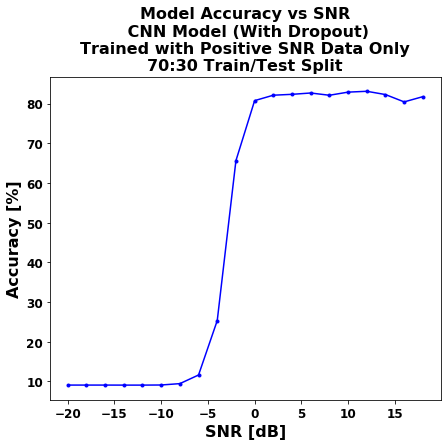

In [42]:
plt.figure(figsize=(6,6))
plt.plot(snr_types, snr_accuracy_array,'b.-')
plt.title('Model Accuracy vs SNR\n CNN Model (With Dropout)\nTrained with Positive SNR Data Only\n70:30 Train/Test Split', \
          fontweight='bold', fontsize=16)
plt.tight_layout()
plt.xlabel('SNR [dB]', fontsize=16, fontweight='bold')
plt.ylabel('Accuracy [%]', fontsize=16, fontweight='bold')
plt.xticks(fontweight='bold', fontsize=12)
plt.yticks(fontweight='bold', fontsize=12)
# plt.savefig('accuracy_vs_snr_dropout_7030_pos_snr.png',bbox_inches='tight')

plt.savefig('accuracy_vs_snr_final.png',bbox_inches='tight')
plt.show

### 3.2.5.3 Plot Model Accuracy vs SNR (Paper Version)

<function matplotlib.pyplot.show(*args, **kw)>

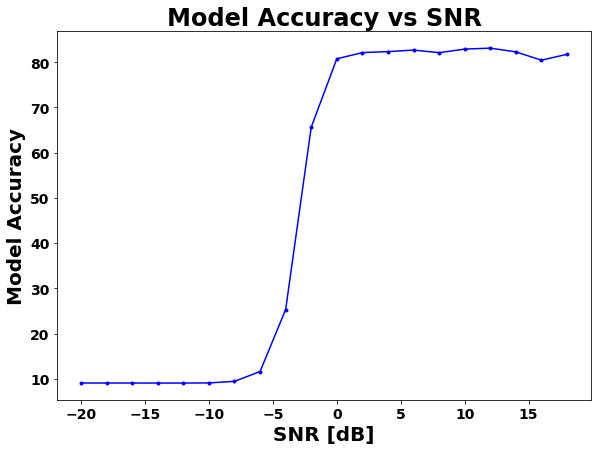

In [43]:
plt.figure(figsize=(8,6))
plt.plot(snr_types, snr_accuracy_array,'b.-')
plt.title('Model Accuracy vs SNR', \
          fontweight='bold', fontsize=24)
plt.tight_layout()
plt.xlabel('SNR [dB]', fontsize=20, fontweight='bold')
plt.ylabel('Model Accuracy', fontsize=20, fontweight='bold')
plt.xticks(fontweight='bold', fontsize=14)
plt.yticks(fontweight='bold', fontsize=14)
plt.savefig('accuracy_vs_snr_final.png',bbox_inches='tight')
plt.show

## 3.2.6 Function for Plotting Confusion Matrixes

In [44]:
# Function for plotting confusion matrixes
def plot_cm(conf_mat, title, filename):
    plt.figure(figsize=(12,8))
    plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title, fontweight='bold', fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(num_mods)
    plt.xticks(tick_marks, modulation_types, rotation=45, fontweight='bold', fontsize=12)
    plt.yticks(tick_marks, modulation_types, fontweight='bold', fontsize=12)
    plt.tight_layout()
    plt.ylabel('True Modulation', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Modulation', fontsize=16, fontweight='bold')
    plt.ylim(num_mods - 0.5, -0.5)
    plt.grid(True, color='white')
    plt.savefig(filename,bbox_inches='tight')
    plt.show

## 3.2.7 Plot Confusion Matrix for Each SNR

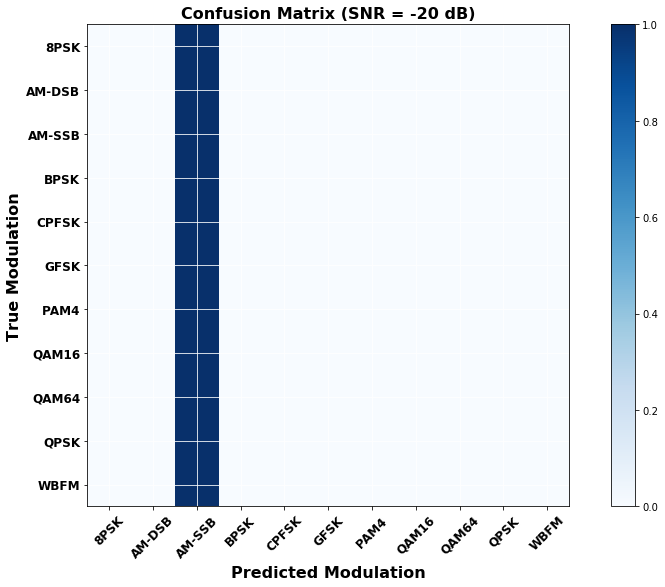

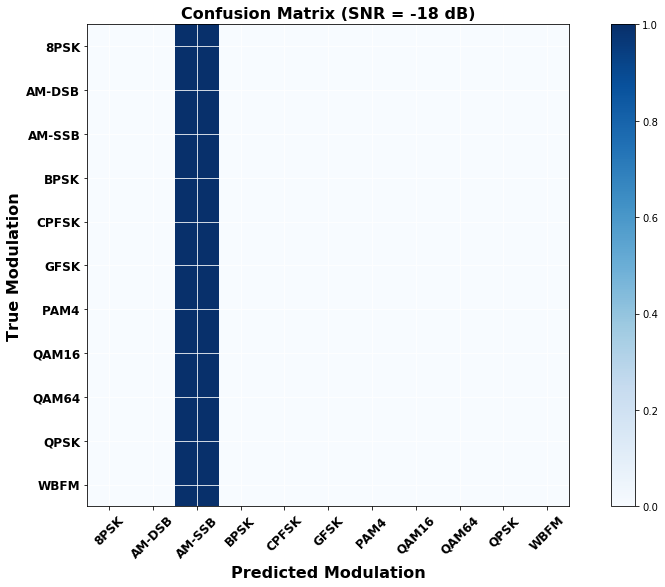

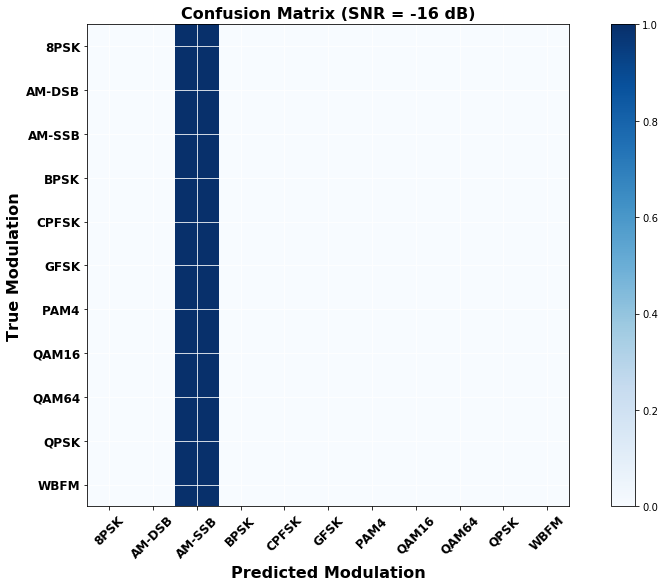

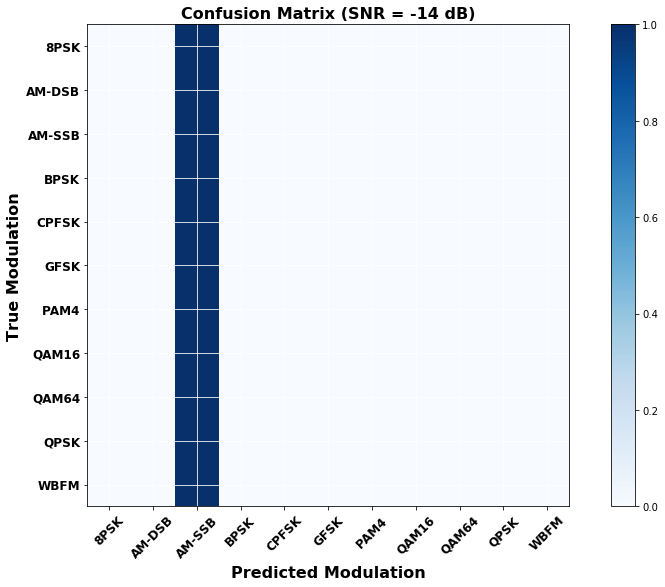

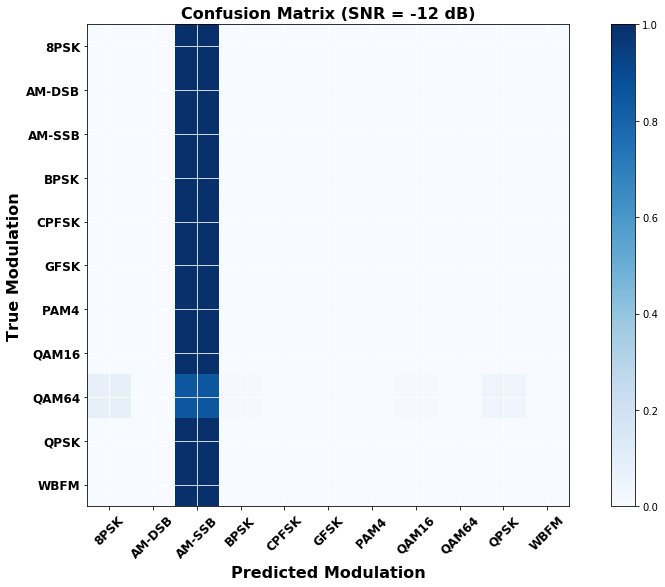

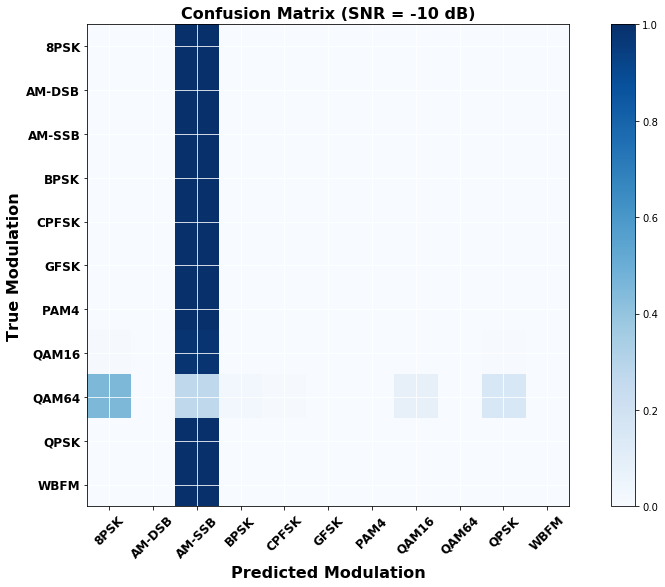

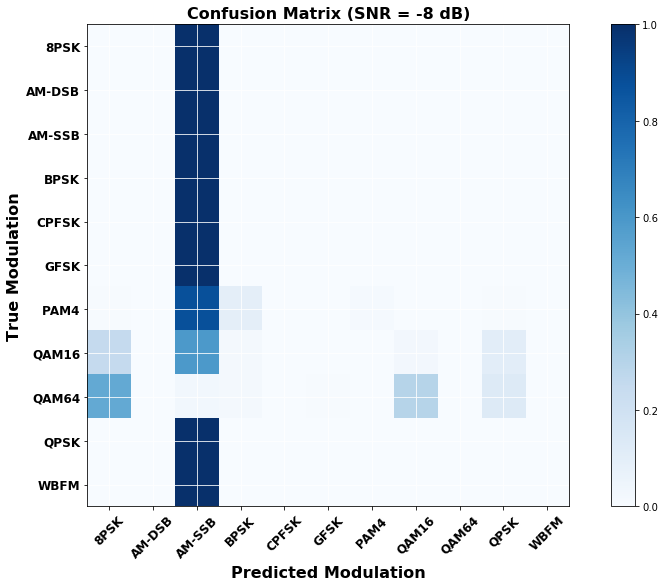

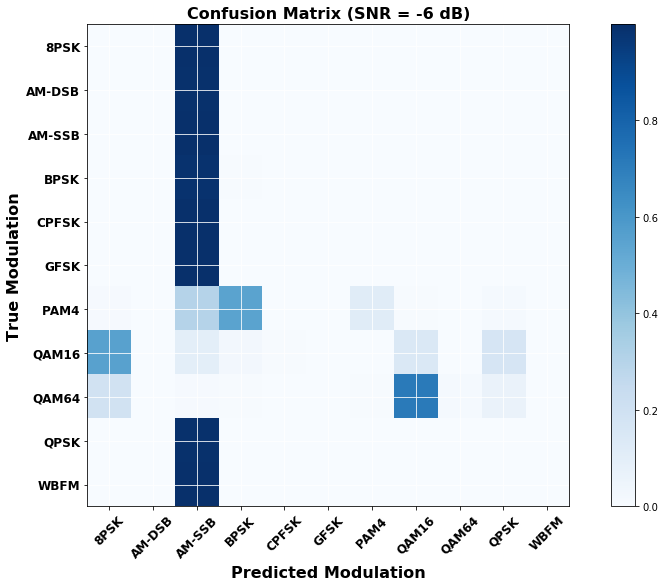

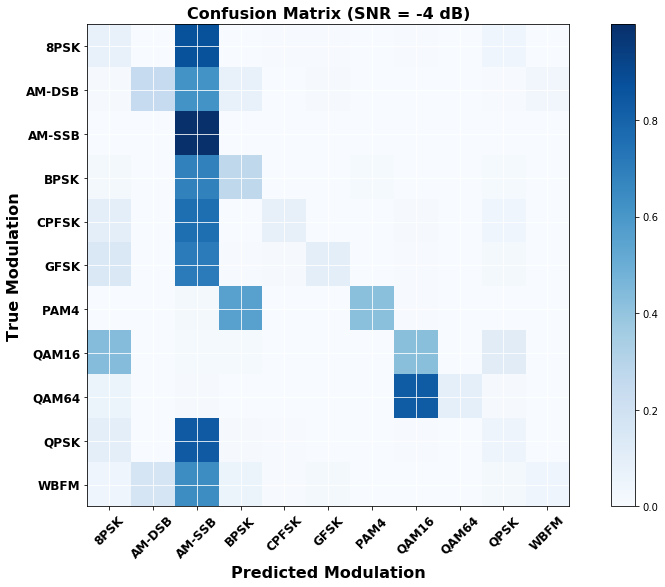

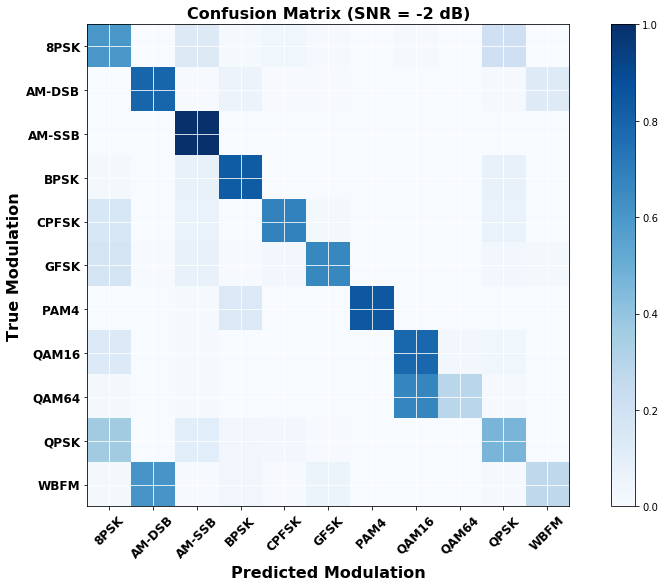

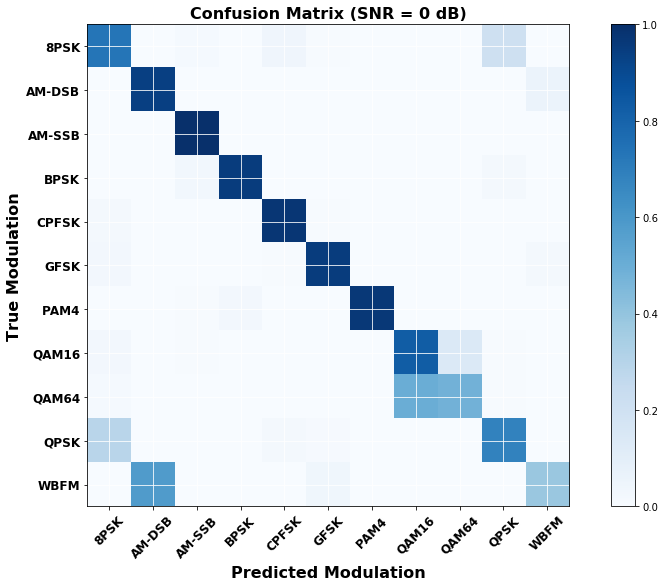

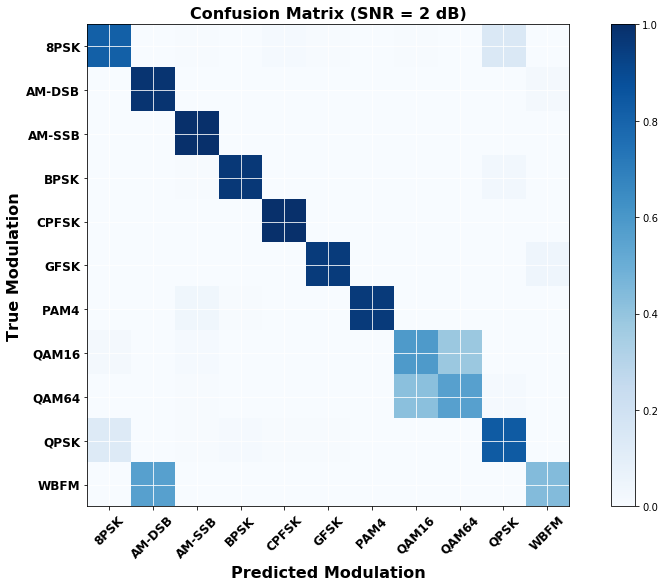

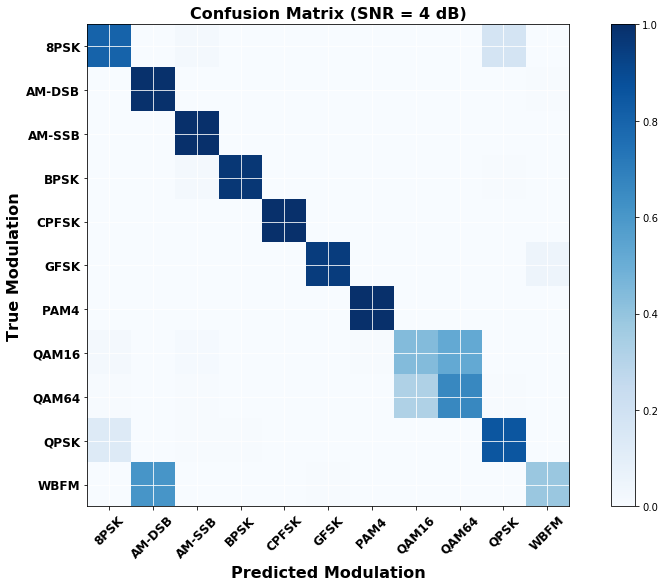

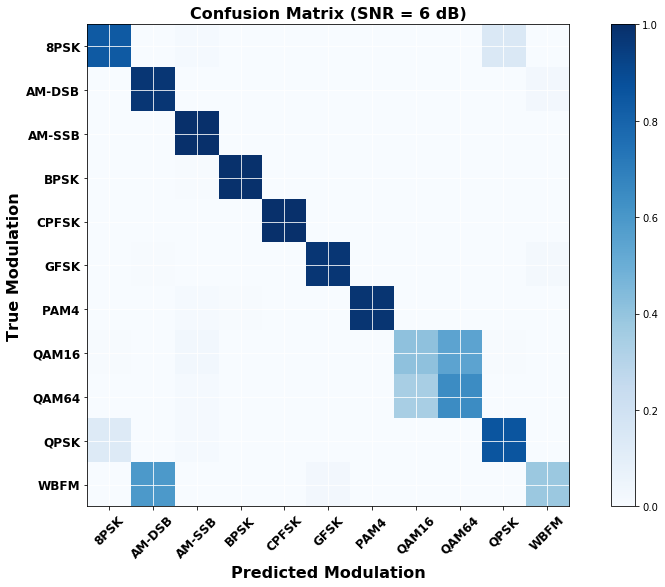

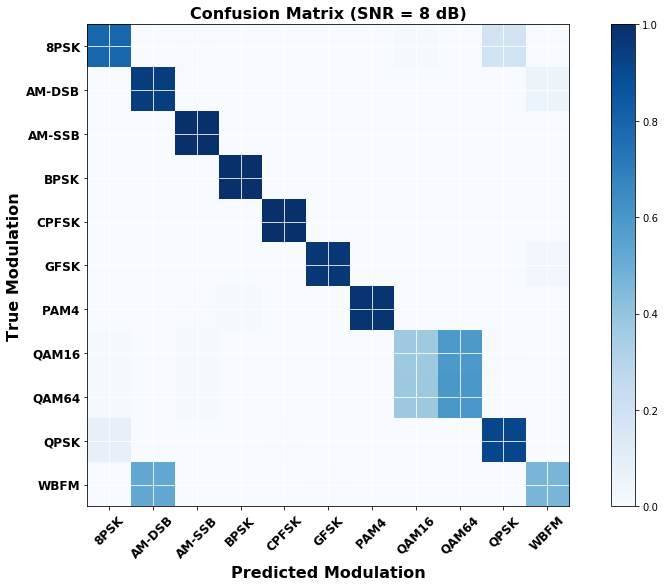

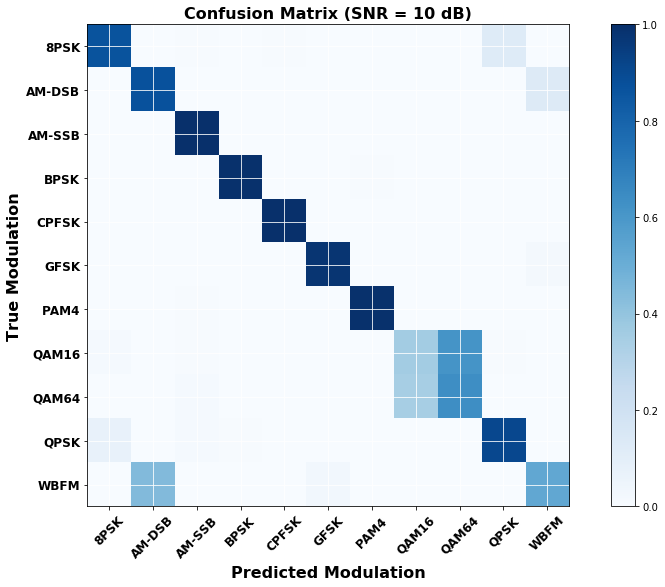

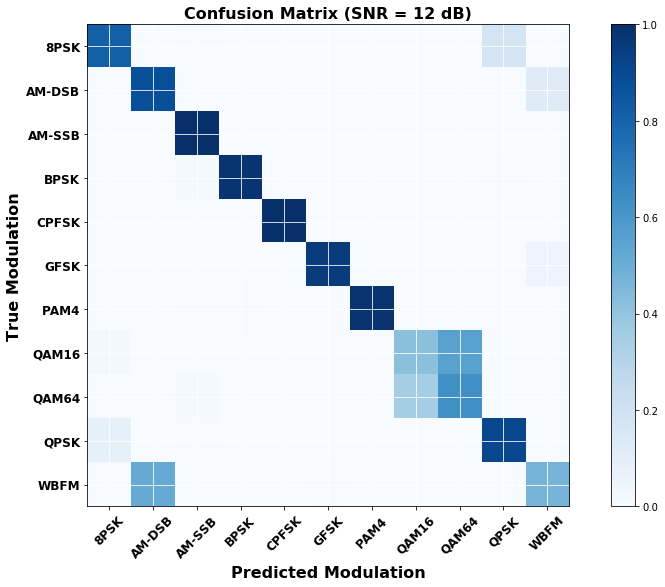

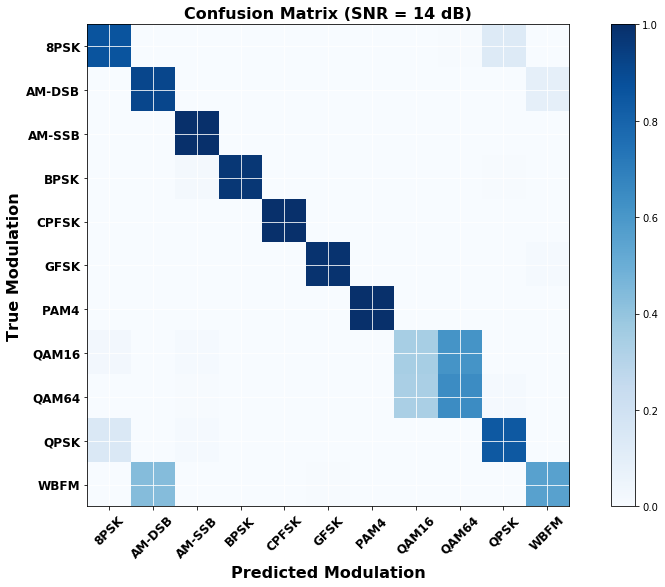

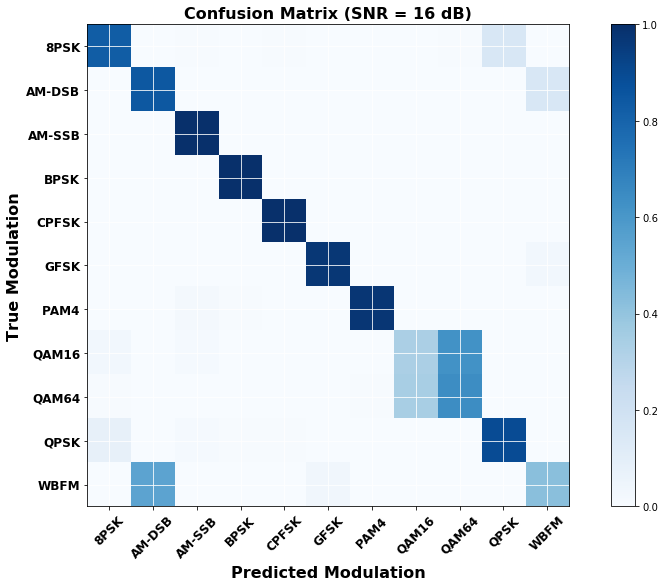

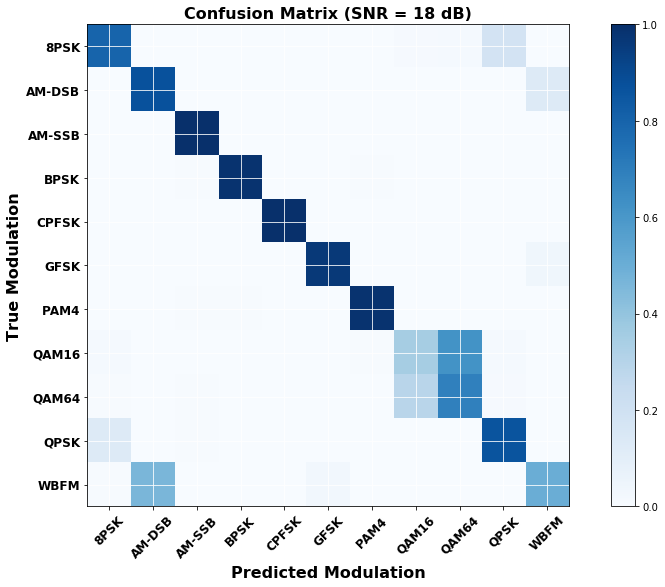

In [45]:
for snr_int in range(-20,20,2):
    snr_str = str(snr_int)
    plot_cm(confusion_pcts[snr_str], title="Confusion Matrix (SNR = %d dB)"%(snr_int), 
            filename="ConfMat_%ddB.png"%(snr_int))

# 4. Miscellaneous

## 4.1 Hyperparameter Tuning Results

In [46]:
import pandas as pd

lr = [0.01, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.005, 0.001] #learning rate
opt = ["SGD", "SGD", "SGD", "SGD", "SGD", "SGD", "SGD", "SGD", "SGD", "SGD"] #optimizer used
acc = [24.458, 24.587, 25.315, 24.500, 25.283, 24.932, 23.896, 24.552, 24.659, 25.220] #accuracy of all
dropout = ["yes, 1 layer 50%", "yes, 3 layers 50%", "yes, 3 layers 50%", "yes 3 layers 50%", "yes 3 layers 60%", "yes 3 layers 60%","yes 3 layers 70%", "yes 3 layers 70%","yes 3 layers 70%", "yes 3 layers 55%" ] #was dropout used?
ec = [25, 25, 100, 43, 100, 150, 100, 150, 100, 100] #epoch count

df = pd.DataFrame(list(zip(lr, opt, acc, dropout, ec)), columns =['Learning Rate', 'Optimizer', 'Accuracy', 'Dropout', 'Num Epochs'])


df.head(9)

,Learning Rate,Optimizer,Accuracy,Dropout,Num Epochs
0,0.010,SGD,24.458,"yes, 1 layer 50%",25
1,0.001,SGD,24.587,"yes, 3 layers 50%",25
2,0.001,SGD,25.315,"yes, 3 layers 50%",100
3,0.001,SGD,24.500,yes 3 layers 50%,43
4,0.001,SGD,25.283,yes 3 layers 60%,100
5,0.001,SGD,24.932,yes 3 layers 60%,150
6,0.001,SGD,23.896,yes 3 layers 70%,100
7,0.001,SGD,24.552,yes 3 layers 70%,150
8,0.005,SGD,24.659,yes 3 layers 70%,100


### Notes
 - The motivation on line 3 for 43 epochs is because on line 2, the data started overfitting after 40ish epochs.
 - Conv layers are untouched.
 - Momentum = 0.9 for all of these.
 - SGD Optimizer for all of these.